In [277]:
from matplotlib import pyplot as plt
import yfinance as yf
import pandas as pd
import numpy as np
from helpers import Trade

plt.style.use('Solarize_Light2')
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

# **1. Loading & Cleaning Data**

In [278]:
gold_ticker = yf.Ticker("GC=F")
# gold_ticker = yf.Ticker("NQ=F")

df = gold_ticker.history(period="1y", interval='1h')

df.drop(columns=['Volume', 'Dividends', 'Stock Splits'], inplace=True)

# display(df.shape)

# display(df.head(3))

- visualizing data

<Axes: title={'center': 'Closing price'}, xlabel='Datetime', ylabel='price'>

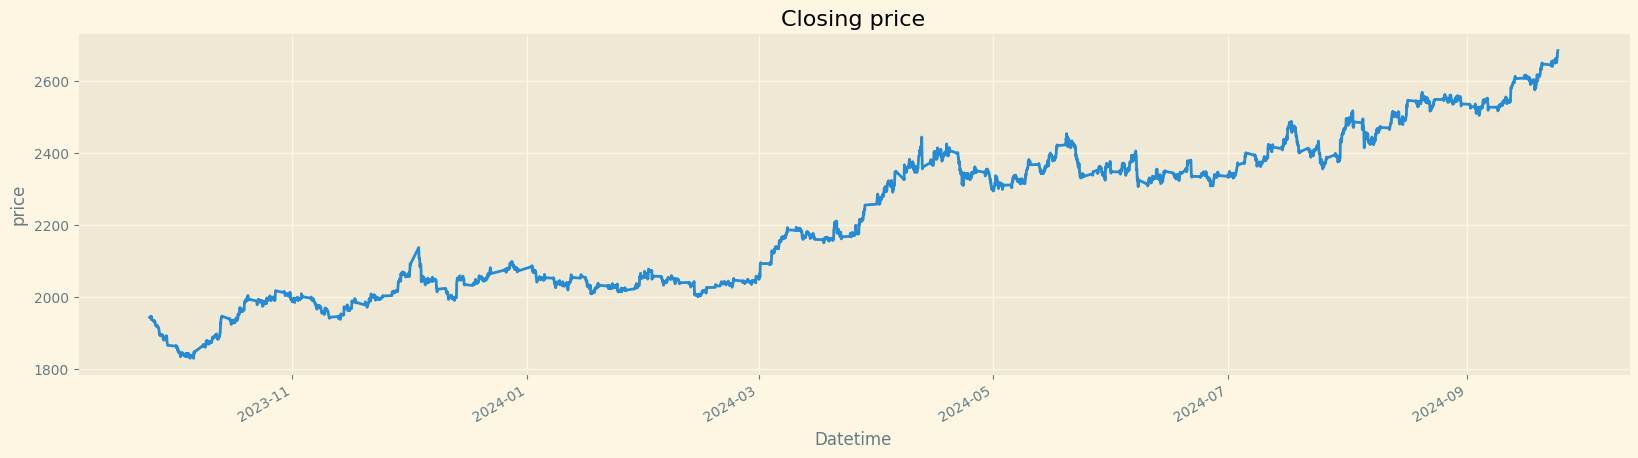

In [279]:
df['Close'].plot(xlabel=None, ylabel='price', title="Closing price", figsize=(20,5))


# **Loading constants needed**

In [280]:
import json

with open('prams.json', 'r') as file:
    data = json.load(file)

WINDOW, PNL, SIGNALS, PRICE_DEVIATION, POSITIONS_NATURE, POSITIONS_SHORTCUT=data['WINDOW'], data['PNL'], data['SIGNALS'], data['PRICE_DEVIATION'], data['POSITIONS_NATURE'], data['POSITIONS_SHORTCUT']

# **2. Defining the Strategy (Mean Reversion)**

### We will create Columns needed

In [281]:
# Low
df['Mean_L'] = df['Low'].rolling(window=WINDOW).mean()
df['STD_L'] = df['Low'].rolling(window=WINDOW).std()
df['Z-Score_L'] = (df['Low'] - df['Mean_L']) / df['STD_L']

# High
df['Mean_H'] = df['High'].rolling(window=WINDOW).mean()
df['STD_H'] = df['High'].rolling(window=WINDOW).std()
df['Z-Score_H'] = (df['High'] - df['Mean_H']) / df['STD_H']

df.dropna(inplace=True)

display(df.head(3))

,Open,High,Low,Close,Mean_L,STD_L,Z-Score_L,Mean_H,STD_H,Z-Score_H
Datetime,,,,,,,,,,
2023-09-25 00:00:00-04:00,1942.900024,1943.000000,1942.199951,1942.500000,1942.871408,1.014423,-0.661910,1944.428554,1.181411,-1.209194
2023-09-25 01:00:00-04:00,1942.400024,1942.900024,1940.900024,1941.099976,1942.342843,0.923496,-1.562345,1943.971418,1.037170,-1.032998
2023-09-25 02:00:00-04:00,1941.000000,1944.599976,1940.099976,1943.599976,1941.785697,0.933494,-1.805818,1943.857125,0.886666,0.837802


### Overview

<Axes: ylabel='Z-Score'>

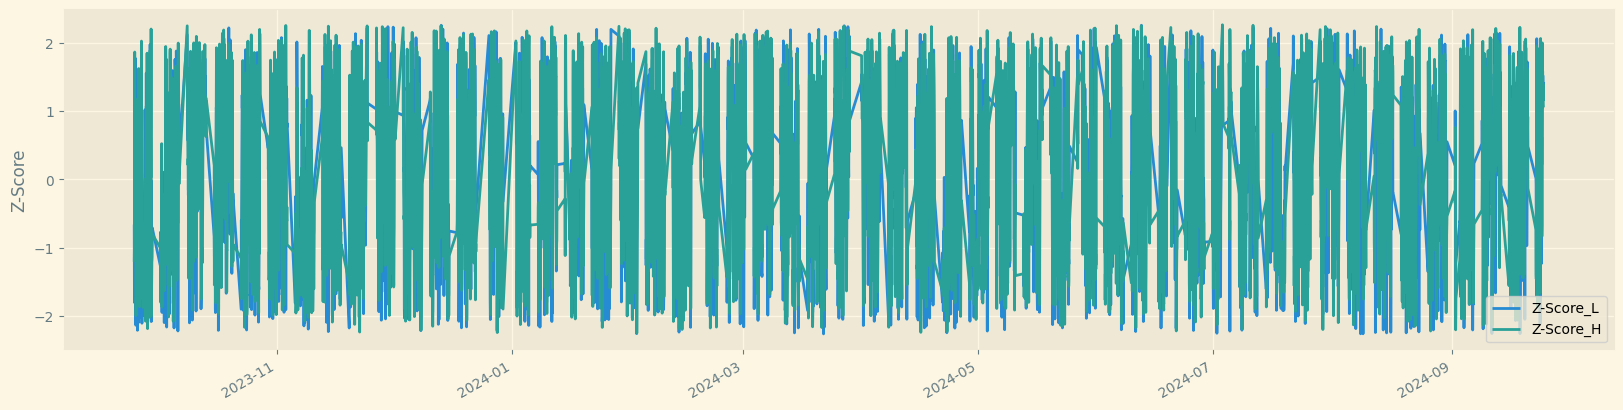

In [282]:
df[['Z-Score_L', 'Z-Score_H']].plot(kind='line', figsize=(20, 5), xlabel='', ylabel="Z-Score")

<Axes: ylabel='price'>

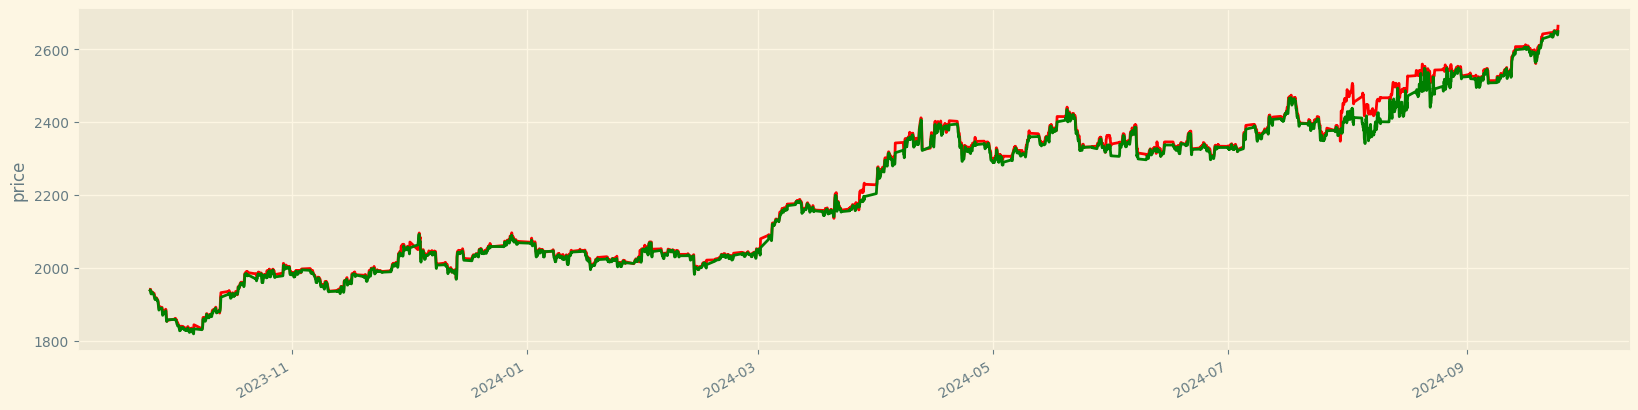

In [283]:
(df['Mean_H'] - PRICE_DEVIATION['ENTRY'] * df['STD_H']).plot(kind='line', figsize=(20, 5), xlabel='', color="red", ylabel="price")
(df['Mean_L'] - PRICE_DEVIATION['ENTRY'] * df['STD_L']).plot(kind='line', figsize=(20, 5), xlabel='', color="green", ylabel="price")

,Z-Score_L,Z-Score_H
max,2.258415,2.265128
min,-2.264885,-2.253621


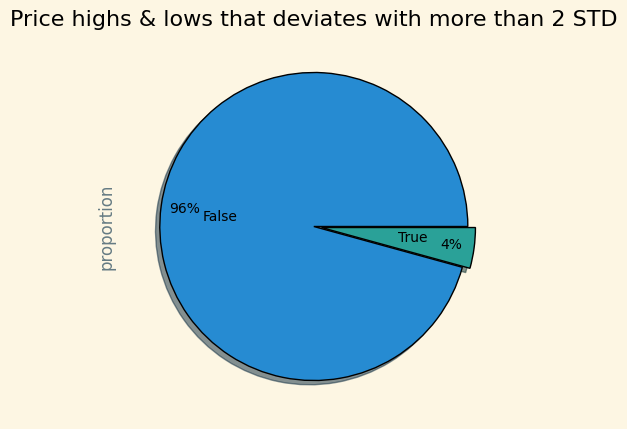

In [284]:
# same for Z-Score_H
stats = (abs(df['Z-Score_L']) > PRICE_DEVIATION['ENTRY']).value_counts(normalize=True)

stats.plot(
    kind='pie', 
    figsize=(5, 5),
    title=f"Price highs & lows that deviates with more than {PRICE_DEVIATION['ENTRY']} STD",
    autopct='%1.0f%%',
    pctdistance=0.85,
    labeldistance=0.5,
    shadow=True,
    explode=[0, 0.05],
    wedgeprops={'edgecolor': 'black'},
    # colors=["#ECDFCC", "#3C3D37"]
)

df[['Z-Score_L', 'Z-Score_H']].agg(['max', 'min'])

### Generate buy/sell signals

In [285]:
df['Signal'] = 0  # Default to hold/no position
df.loc[df['Z-Score_L'] < -PRICE_DEVIATION['ENTRY'], 'Signal'] = SIGNALS['BUY'] # Buy signal
df.loc[df['Z-Score_H'] > PRICE_DEVIATION['ENTRY'], 'Signal']= SIGNALS['SELL']  # Sell signal

# [TODO] what if a candel has both signals buy and sell

# **3. Implementing Stop Loss and Take Profit**

In [286]:
df.reset_index(inplace=True)

# Initialize trade tracking columns
df['Position'] = 0  # Track if we're in a trade (1 for long, -1 for short)
df['Entry_Price'] = 0.0  # Track entry price
df['Exit_Price'] = 0.0  # Track exit price
df['PnL'] = 0.0  # Track Profit and Loss for each trade

# Simulate the strategy with SL/TP
trade = Trade()

def is_buy_sl(i: int):
    if df.loc[i, 'Low'] <= trade.sl:  # SL hit
        df.loc[i, 'Exit_Price'] = trade.sl
        df.loc[i, ['PnL', 'Position']] = [PNL['LOSS'], SIGNALS['BUY']]
        return True
    return False

def is_buy_tp(i: int, source='High'):
    if df.loc[i, source] > trade.tp:  # TP hit
        df.loc[i, 'Exit_Price'] = trade.tp
        df.loc[i, ['PnL', 'Position']] = [PNL['WIN'], SIGNALS['BUY']]
        return True
    return False

def is_sell_sl(i: int):
    if df.loc[i, 'High'] >= trade.sl:  # SL hit
        df.loc[i, 'Exit_Price'] = trade.sl
        df.loc[i, ['PnL', 'Position']] = [PNL['LOSS'], SIGNALS['SELL']]
        return True
    return False

def is_sell_tp(i: int, source='Low'):
    if df.loc[i, source] < trade.tp:  # TP hit
        df.loc[i, 'Exit_Price'] = trade.tp
        df.loc[i, ['PnL', 'Position']] = [PNL['WIN'], SIGNALS['SELL']]
        return True
    return False

# [NB] check sl first then make sure trade is On to check tp

def fill_trade_params(_row, idx):
    trade_signal = _row['Signal']
    L_H = POSITIONS_SHORTCUT[str(trade_signal)]
    mean_kw, std_kw = f"Mean_{L_H}", f"STD_{L_H}"
    trade.On()
    trade.entry = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['ENTRY'] * _row[std_kw])
    trade.tp = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['TP'] * _row[std_kw])
    trade.sl = (_row[mean_kw] - trade_signal * PRICE_DEVIATION['SL'] * _row[std_kw])
    df.loc[idx, ['Position', 'Entry_Price']] = [trade_signal, trade.entry]

    # check if sl or tp is already hit in the same candel (i)
    if trade_signal == SIGNALS['BUY']:
        if is_buy_sl(idx): trade.Off()
        elif is_buy_tp(idx, source='Close'): trade.Off()
    elif trade_signal == SIGNALS['SELL']:
        if is_sell_sl(idx): trade.Off()
        elif is_sell_tp(idx, source='Close'): trade.Off()

for i, row in df.iterrows(): # row for reading, i for writing
    row = df.loc[i]
    if trade.on: 
        # Track price movement for Stop Loss or Take Profit
        if trade.is_buy: 
            if is_buy_sl(i): trade.Off()
            elif is_buy_tp(i, source='Close'): trade.Off()
        elif trade.is_sell:
            if is_sell_sl(i): trade.Off()
            elif is_sell_tp(i, source='Close'): trade.Off()
    else:
        if row['Signal'] != 0: # Check if there's a signal
            fill_trade_params(row, i)

# **4. Backtesting & Overview**

In [287]:
# Calculate cumulative profit/loss
df['Cumulative_PnL'] = df['PnL'].cumsum()

# Filter rows where we had a trade exit
trades = df[df['PnL'] != 0]

# Summary statistics
total_trades = len(trades)
total_pnl = df['Cumulative_PnL'].iloc[-1]  # Total profit/loss
PnL = trades['PnL'].value_counts(normalize=True)
win_rate = 0
if not PnL.empty:
    win_rate = trades['PnL'].value_counts(normalize=True).loc[1]

RRR = (PRICE_DEVIATION['ENTRY'] - PRICE_DEVIATION['TP'])/(PRICE_DEVIATION['SL'] - PRICE_DEVIATION['ENTRY'])

strategy_stats_df = pd.DataFrame(
    np.array([[
        total_trades,
        total_pnl,
        round(win_rate * 100, 2),
        RRR,
        (RRR + 1) * win_rate - 1
    ]]),
    columns=['Total Trades', 'Total Profit/Loss (RR)', 'Win rate (%)', 'Risk-Reward Ratio', 'Expectancy']
)
strategy_stats_df

# [TODO] calc expectency

,Total Trades,Total Profit/Loss (RR),Win rate (%),Risk-Reward Ratio,Expectancy
0,284.0,202.0,85.56,0.333333,0.140845


- **PnL**

<Axes: title={'center': 'PnL'}, xlabel='Datetime', ylabel='RR | %'>

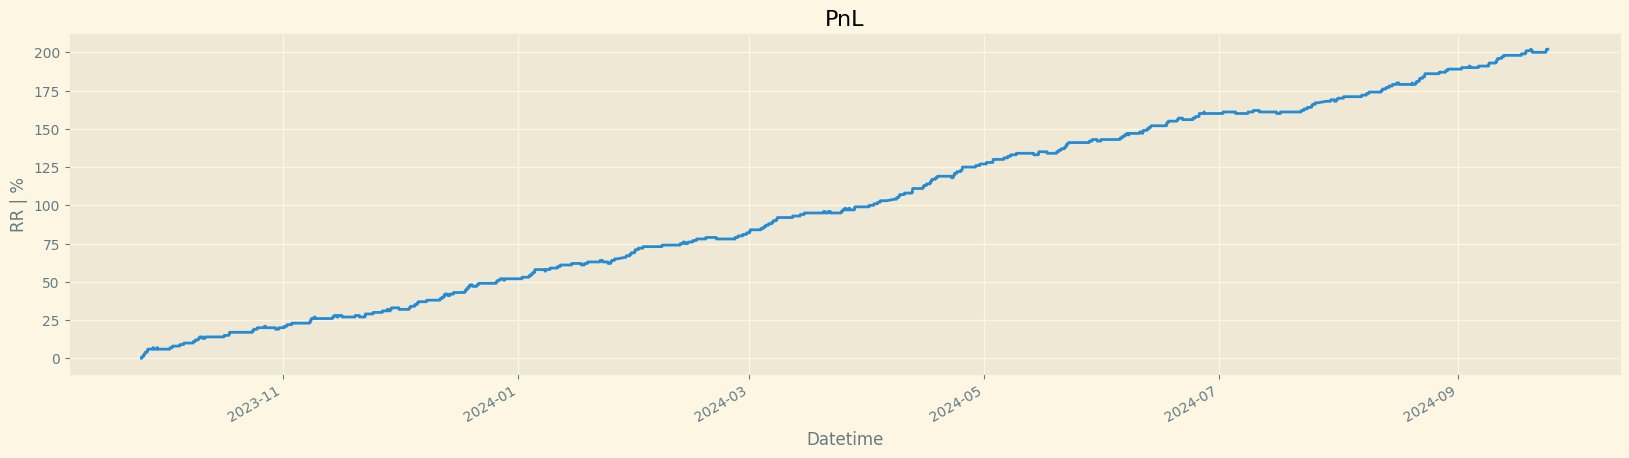

In [288]:
df.set_index('Datetime', inplace=True)

df['Cumulative_PnL'].plot(
    kind='line', 
    figsize=(20, 5), 
    title="PnL",
    ylabel="RR | %"
)

- **PnL-Drawdown** (not from Equity)

<Axes: title={'center': 'PnL-Drawdown'}, xlabel='Datetime', ylabel='RR | %'>

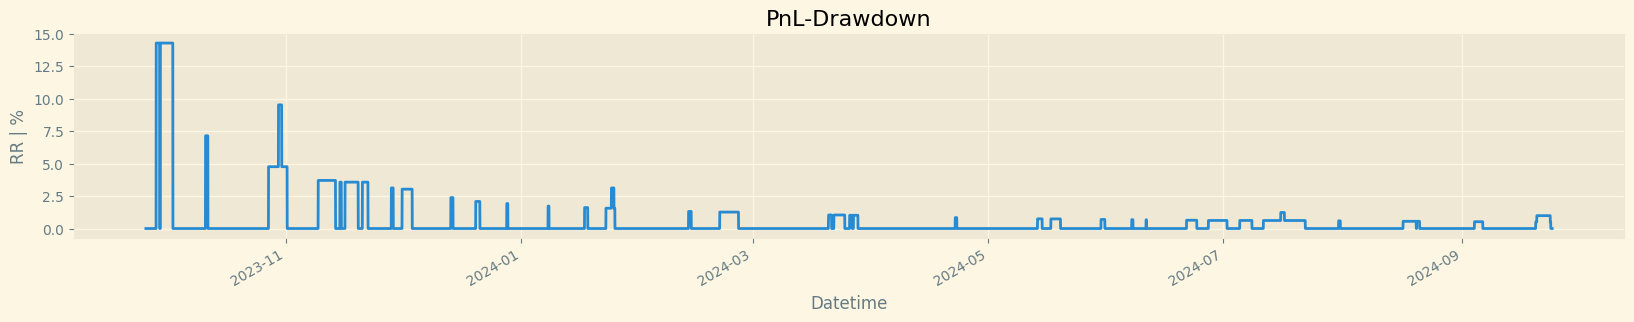

In [289]:
df['Peak'] = df['Cumulative_PnL'].cummax()

df['Drawdown'] = (df['Peak'] - df['Cumulative_PnL']) / df['Peak']

# df['Drawdown'] = df.apply(lambda row: ((row['Peak'] - row['Cumulative_PnL']) / row['Peak']) if row['Peak'] != 0 else 0, axis=1)

# df['Drawdown'] = np.where(df['Peak'] != 0, (df['Peak'] - df['Cumulative_PnL']) / df['Peak'], 0)

(df['Drawdown'] * 100).plot(
    kind='line', 
    figsize=(20, 3), 
    title="PnL-Drawdown",
    ylabel="RR | %",
)

In [290]:
print(f"Max PnL-drawdown is {round(100 * df['Drawdown'].max(), 2)} %")

Max PnL-drawdown is 14.29 %


# **5. A study on Drawdown**

In [291]:
# [TODO] periods where drawdown (over 50%) happened

# **6. Overview on positions**

<Axes: >

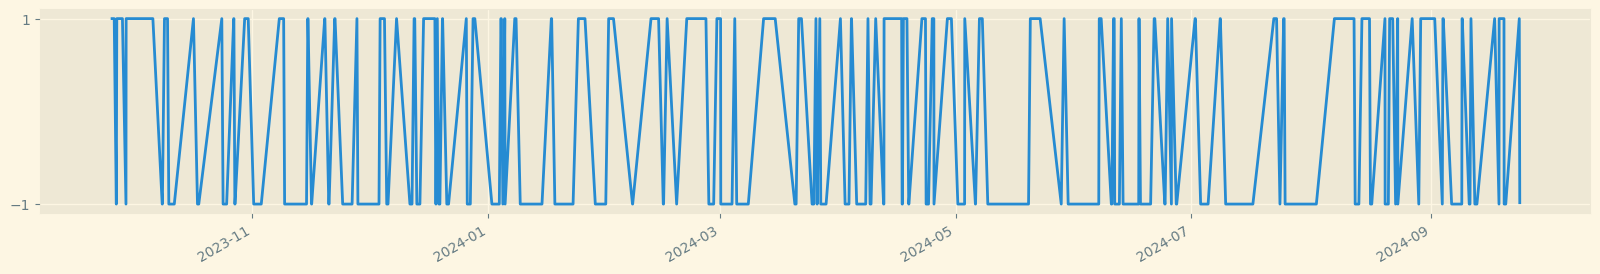

In [292]:
filtrty = df['Position'] != 0

df.loc[filtrty, 'Position'].plot(kind='line', figsize=(20, 3), xlabel='', yticks=[-1, 1])

<Axes: title={'center': 'Positions nature distribution'}, ylabel='proportion'>

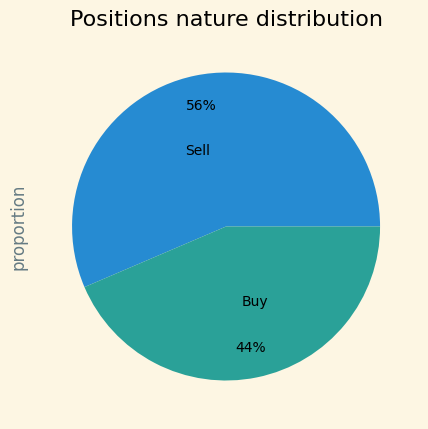

In [293]:
positions_nature_distribution_df = df.loc[filtrty, 'Position'].value_counts(normalize=True)

positions_nature_distribution_df.index = [POSITIONS_NATURE[str(x)] for x in positions_nature_distribution_df.index.to_list()]

positions_nature_distribution_df

positions_nature_distribution_df.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Positions nature distribution",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

# [TODO] probability distribution

<Axes: title={'center': 'Percentage of Buy & Short from losing positions'}, ylabel='proportion'>

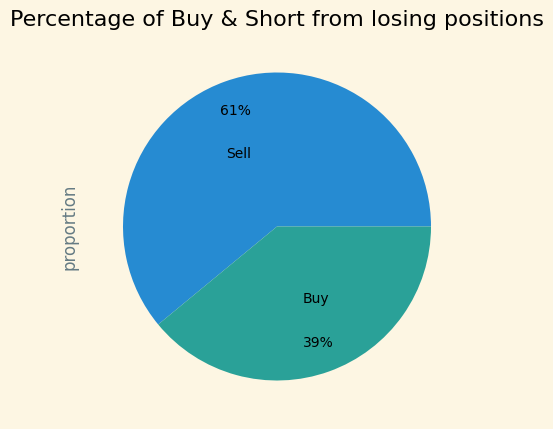

In [294]:
losing_positions_sr = df.loc[df['PnL'] == -1, 'Position'].value_counts(normalize=True)

losing_positions_sr.index = [POSITIONS_NATURE[str(x)] for x in losing_positions_sr.index.to_list()]

losing_positions_sr.plot(
    kind='pie', 
    figsize=(5, 5),
    title="Percentage of Buy & Short from losing positions",
    autopct='%1.0f%%',
    pctdistance=0.8,
    labeldistance=0.5
)

In [295]:
# [TODO] max consecutive wins & losses (so we can avoid drawdown)